In [1]:
from pet.utilities import get_quadrature
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import chemiscope
import ase, ase.io
import cmocean
import ipi

ha2ev = 27.211386

Failed to load neighbors_convert.so: /home/michele/local/venvs/default/lib/python3.12/site-packages/pet/neighbors_convert.so: undefined symbol: _ZN2at23SavedTensorDefaultHooks11set_tracingEb


In [2]:
# define ~design~

cmap = cmocean.cm.balance

# we mostly only need two colors. let's go with good old black and red
red = "#F64422"
blue = "black"
extra = "#0077BB"  # actual blue in case black makes no sense


# LaTeX time
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 11,
})

# Helvetica lookalike with fitting math fonts
plt.rcParams['text.latex.preamble'] = r"""
\usepackage{tgheros}
\usepackage{sansmath}
\sansmath
% adjust spacing on Å (sigh)
\usepackage{stackengine}
\def\AA{\stackinset{c}{0.05pt}{t}{-1.84pt}{\r{}}{A}}
"""


# Fig. 1 - Molecule

This figure contains:

(a) the angular momentum trajectory for a water molecule in vacuum, from a converged PET model (PET3 in our language) and a L=2i augmentation (36 rotations)

(b) inset with the mean magnitude of the torque, for different levels of augmentation

(c) power spectrum of the overall potential, and of the non-equivariant part

(d-e) absolute orientation FES

In [3]:
# loads NVE trajectory of molecule
nve_pet3 = np.loadtxt("data/nve_pet3.dat")
nve_pet3_2i = np.loadtxt("data/nve_pet3-aug2i.dat")

In [4]:
# loads the data for the convergence of the rotational augmentation
augs = {"0":1, "i": 2, "2" : 18, "2i": 36, "3" : 75, "3i": 150} # "label" : n_rotations
torque = {}
for a in augs:
    data = np.loadtxt(f"data/mm-{a}.dat")
    torque[a] = np.sqrt( (data[:,5:8]**2).sum(axis=1).mean() )   

In [5]:
# loads the FT of the power spectrum. units here are fs^-1 and hartree^2 so we convert to cm^-1 and eV^2
ps_pet3delta = np.loadtxt("data/nve_pet3-delta_powerspec.dat") * np.array([5308.8375, 740.45954, 740.45954])[np.newaxis,:]
# slight smoothing
ps_pet3delta[:-2] = (ps_pet3delta[:-2]*0.5 + ps_pet3delta[1:-1] + ps_pet3delta[2:]*0.5) / 2
ps_pet3delta = ps_pet3delta[::4]

In [6]:
# loads the polar histograms
pol_pet3 = np.loadtxt("data/pfes_pet3.dat")
pol_pet32i = np.loadtxt("data/pfes_pet3-2i.dat")

In [7]:
fig, ax = plt.subplot_mosaic(
    """
    AA
    BB
    CC
    DE
    """,
    figsize=(5,8),
    height_ratios=[2,1,2,2.5],
    constrained_layout=True)

# momentum 

ax["A"].plot(nve_pet3_2i[:,0],nve_pet3_2i[:,2]*1e3, ':', color=blue)
ax["A"].plot(nve_pet3_2i[:,0],nve_pet3_2i[:,3]*1e3, ':', color=blue)
ax["A"].plot(nve_pet3_2i[:,0],nve_pet3_2i[:,4]*1e3, ':', color=blue)
ax["A"].plot(nve_pet3_2i[:,0],np.sqrt((nve_pet3_2i[:,2:5]**2).sum(axis=1))*1e3, label=r"PET, 2i avg.", color=blue, linewidth=3)

ax["A"].plot(nve_pet3[:,0],nve_pet3[:,2]*1e3, ':', color=red)
ax["A"].plot(nve_pet3[:,0],nve_pet3[:,3]*1e3, ':', color=red)
ax["A"].plot(nve_pet3[:,0],nve_pet3[:,4]*1e3, ':', color=red)
ax["A"].plot(nve_pet3[:,0],np.sqrt((nve_pet3[:,2:5]**2).sum(axis=1))*1e3, label="PET, no avg.", color=red)

ax["A"].set_xlabel(r"$t$ (ps)")
ax["A"].set_ylabel(r"$L_{\alpha}, |L|$ (eV fs)")

handles, labels = ax["A"].get_legend_handles_labels()
ax["A"].legend(handles[::-1], labels[::-1], loc='lower right', ncol=2, framealpha=0.5)  # reverse order
ax["A"].set_xlim(-1,25)
ax["A"].set_ylim(-5.5, 3.5)

ax['A'].text(-0.2,-4.9, r"\textbf {\large a}")

# torque convergence with augmentation
# no longer using inset due to reviewer comments
# ax0_pos = [0.55,0.55,0.44,0.33]
# ax0_inset = ax["A"].inset_axes(ax0_pos)
# ax["A"].add_patch(
#     mpl.patches.Rectangle((ax0_pos[0]-0.16,ax0_pos[1]-0.25), ax0_pos[2]+0.23, ax0_pos[3]+0.26,
#                           color='white', alpha=0.7, transform=ax["A"].transAxes, zorder=4)
# )

# ax0_inset.loglog([augs[a] for a in augs], [torque[a] for a in augs], 'k--*')
# ax0_inset.set_ylabel(r"$\langle |\tau|\rangle$ (eV)", labelpad=0)
# ax0_inset.set_xlabel(r"Averaging grid", labelpad=0)
# ax0_inset.set_xticks(list(augs.values()))
# ax0_inset.set_xticklabels([r"$\mathrm{" + k + r"}$" for k in list(augs.keys())])
# ax0_inset.xaxis.set_minor_locator(plt.NullLocator())

ax['B'].loglog([augs[a] for a in augs], [torque[a] for a in augs], 'k--*')
ax['B'].set_ylabel(r"$\langle |\tau|\rangle$ (eV)", labelpad=0)
ax['B'].set_xlabel(r"Averaging grid", labelpad=0)
ax['B'].set_xticks(list(augs.values()))
ax['B'].set_xticklabels([r"$\mathrm{" + k + r"}$" for k in list(augs.keys())])
ax['B'].xaxis.set_minor_locator(plt.NullLocator())

ax['B'].text(0.035, 0.13, r"\textbf {\large b}", transform=ax['B'].transAxes)

ax['C'].semilogy(ps_pet3delta[:,0], ps_pet3delta[:,1], '-', label="PET", color=red, linewidth=2.5)
ax['C'].semilogy(ps_pet3delta[:,0], ps_pet3delta[:,2], linestyle="solid", label=r"$\mathrm{\Delta}$PET", color=blue)
ax['C'].set_xlabel(r"$\omega$ (cm$^{-1}$)")
ax['C'].set_ylabel(r"$c_{VV}$ (eV$^2$)")
ax['C'].legend()
ax['C'].text(0.035, 0.075, r"\textbf {\large c}", transform=ax['C'].transAxes)

xgrid = np.linspace(-1,1,pol_pet3.shape[0])
ygrid = np.linspace(0,2*np.pi,pol_pet3.shape[1])
ctrD=ax['D'].pcolormesh(xgrid, ygrid, -np.log(pol_pet3.T), vmin=-0.4, vmax=0.4, cmap=cmap, rasterized="True")
ctrE=ax['E'].pcolormesh(xgrid, ygrid, -np.log(pol_pet32i.T), vmin=-0.4, vmax=0.4, cmap=cmap, rasterized="True")
ax['E'].sharey(ax['D'])
ax['E'].tick_params(labelleft=False)
ax['D'].set_xlabel(r"$\cos\theta$")
ax['E'].set_xlabel(r"$\cos\theta$")
ax['D'].set_ylabel(r"$\phi$")
cbar = fig.colorbar(ctrD, ax=[ax['D'], ax['E']], orientation='horizontal', aspect=20)
cbar.ax.set_ylabel(r"$F$ / $k_{\mathrm{B}} T$", rotation=0, labelpad=25, verticalalignment='center')
custom_ticks = np.linspace(-0.4, 0.4, 5)  # Example: five evenly spaced ticks
custom_labels = [f"${tick:.2f}$" for tick in custom_ticks]  # Custom labels as formatted strings
cbar.set_ticks(custom_ticks)
cbar.set_ticklabels(custom_labels)

custom_ticks = [np.pi*i for i in np.linspace(0, 2, 3)]
custom_labels = ["0", r"$\pi$", r"$2\pi$"]
ax["D"].set_yticks(custom_ticks)
ax["D"].set_yticklabels(custom_labels)

labelbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='square,pad=0.2')

fig.text(0.165,0.147, r"\textbf {\large d}", bbox=labelbox)
fig.text(0.61,0.147, r"\textbf {\large e}", bbox=labelbox)

fig.savefig('figures/molecule.pdf')
fig.savefig('figures/molecule.svg')

# Bulk statics

In [8]:
# loads the polar histograms
bulk_pol_pet3 = np.loadtxt("data/bulk_pfes_pet3.dat")
bulk_pol_pet32i = np.loadtxt("data/bulk_pfes_pet3-2i.dat")

In [9]:
# loads the correlation data
bulk_corr_pet3 = np.loadtxt("data/bulk_corr_pet3.dat")
bulk_corr_pet32i = np.loadtxt("data/bulk_corr_pet3-2i.dat")

In [10]:
fig, ax = plt.subplot_mosaic(
    """
    AB
    CC
    DD
    """
    ,figsize=(5,7),
    constrained_layout=True)

xgrid = np.linspace(-1,1,bulk_pol_pet3.shape[0])
ygrid = np.linspace(0,2*np.pi,bulk_pol_pet3.shape[1])
ctrA=ax['A'].pcolormesh(xgrid, ygrid, -np.log(bulk_pol_pet3.T), vmin=-0.4, vmax=0.4, cmap=cmap, rasterized="True")
ctrB=ax['B'].pcolormesh(xgrid, ygrid, -np.log(bulk_pol_pet32i.T), vmin=-0.4, vmax=0.4, cmap=cmap, rasterized="True")
ax['B'].sharey(ax['A'])
ax['B'].tick_params(labelleft=False)
ax['A'].set_xlabel(r"$\cos\theta$")
ax['B'].set_xlabel(r"$\cos\theta$")
ax['A'].set_ylabel(r"$\phi$")

custom_ticks = [np.pi*i for i in np.linspace(0, 2, 3)]
custom_labels = ["0", r"$\pi$", r"$2\pi$"]
ax["A"].set_yticks(custom_ticks)
ax["A"].set_yticklabels(custom_labels)


cbar = fig.colorbar(ctrA, ax=[ax['A'], ax['B']], orientation='horizontal', aspect=20)
cbar.ax.set_ylabel(r"$F$ / $k_{\mathrm{B}} T$", rotation=0, labelpad=25, verticalalignment='center') 
custom_ticks = np.linspace(-0.4, 0.4, 5)  # Example: five evenly spaced ticks
custom_labels = [f"{tick:.2f}" for tick in custom_ticks]  # Custom labels as formatted strings
cbar.set_ticks(custom_ticks)
cbar.set_ticklabels(custom_labels)

ax["C"].plot(bulk_corr_pet3[:,0], bulk_corr_pet3[:,1], '-', label="PET", color=red, linewidth=4.0)
ax["C"].plot(bulk_corr_pet32i[:,0], bulk_corr_pet32i[:,1], label=r"PET, 2i avg.", color=blue, linestyle="dashed", linewidth=1.25)
ax["C"].set_xlabel(r"$r$ (\AA)")
ax["C"].set_ylabel(r"$g_{\mathrm{OO}}(r)$")
ax["C"].set_xlim(2,8)
ax["C"].legend()

ax["D"].plot(bulk_corr_pet3[:,0], bulk_corr_pet3[:,3]/bulk_corr_pet3[:,1], '-', label="PET", color=red, linewidth=4.0)
ax["D"].plot(bulk_corr_pet32i[:,0], bulk_corr_pet32i[:,3]/bulk_corr_pet32i[:,1], label=r"PET, 2i avg.", color=blue, linewidth=1.25)
ax["D"].plot(bulk_corr_pet3[:,0], bulk_corr_pet3[:,5]/bulk_corr_pet3[:,1], '--', color=red, linewidth=3.5)
ax["D"].plot(bulk_corr_pet32i[:,0], bulk_corr_pet32i[:,5]/bulk_corr_pet32i[:,1], color=blue, linewidth=1.25, dashes=[3,1])
ax["D"].set_xlabel(r'$r$ (\AA)')
ax["D"].set_ylabel(r"$c_{uu}(r)$")
ax["D"].set_xlim(2,8)
ax["D"].set_ylim(-0.15,0.4)
ax["D"].legend()
gray_line = mpl.lines.Line2D([0], [0], color='gray', linewidth=2, linestyle='-', label='$c^L_{uu}$')
gray_dash = mpl.lines.Line2D([0], [0], color='gray', linewidth=2, linestyle='--', label='$c^T_{uu}$')
handles, labels = ax["D"].get_legend_handles_labels()
handles.extend([gray_line, gray_dash])
labels.extend([gray_line.get_label(), gray_dash.get_label()])
ax["D"].legend(handles, labels, ncols=2)

labelbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='square,pad=0.2')
fig.text(0.15,0.78, r"\textbf{\large a}", fontweight='bold', fontsize=11, bbox=labelbox)
fig.text(0.6,0.78, r"\textbf{\large b}", fontweight='bold', fontsize=11, bbox=labelbox)
fig.text(0.15,0.42, r"\textbf{\large c}", fontweight='bold', fontsize=11, bbox=labelbox)
fig.text(0.15,0.085, r"\textbf{\large d}", fontweight='bold', fontsize=11, bbox=labelbox)

fig.savefig('figures/bulk-static.pdf')
fig.savefig('figures/bulk-static.svg')

# Time dependent bulk

In [11]:
bulk_tcorr_pet3 = np.loadtxt("data/bulk_tcorr_pet3.dat")
bulk_tcorr_pet32i = np.loadtxt("data/bulk_tcorr_pet3-2i.dat")

In [12]:
fig, ax = plt.subplot_mosaic(
    """
    A
    B
    """
    ,figsize=(5,3.5),sharex=True,
    constrained_layout=True)

# ax["A"].fill_between(bulk_tcorr_pet3[:,0]/1000, 
#                      bulk_tcorr_pet3[:,1]-2*bulk_tcorr_pet3[:,2],
#                      bulk_tcorr_pet3[:,1]+2*bulk_tcorr_pet3[:,2],
#                      color=red, edgecolor='none', alpha=0.5)
# ax["A"].fill_between(bulk_tcorr_pet32i[:,0]/1000, 
#                      bulk_tcorr_pet32i[:,1]-2*bulk_tcorr_pet32i[:,2],
#                      bulk_tcorr_pet32i[:,1]+2*bulk_tcorr_pet32i[:,2],
#                      color=extra, edgecolor='none', alpha=0.5)

ax["A"].plot(bulk_tcorr_pet3[:,0]/1000, bulk_tcorr_pet3[:,1], '-', label="PET", color=red, linewidth=4.0)
ax["A"].plot(bulk_tcorr_pet32i[:,0]/1000, bulk_tcorr_pet32i[:,1], label=r"PET, 2i avg.", color=blue, linestyle="dashed", linewidth=1.5)
#ax["A"].set_xlabel(r"$t$ / ps")
ax["A"].set_ylabel(r"MSD$(t)$  (\AA$^2$)")
ax["A"].set_xlim(0,5)
ax["A"].legend()

# ax["B"].fill_between(bulk_tcorr_pet3[:,0]/1000, 
#                      bulk_tcorr_pet3[:,3]-2*bulk_tcorr_pet3[:,4],
#                      bulk_tcorr_pet3[:,3]+2*bulk_tcorr_pet3[:,4],
#                      color=red, edgecolor='none', alpha=0.5)
# ax["B"].fill_between(bulk_tcorr_pet32i[:,0]/1000, 
#                      bulk_tcorr_pet32i[:,3]-2*bulk_tcorr_pet32i[:,4],
#                      bulk_tcorr_pet32i[:,3]+2*bulk_tcorr_pet32i[:,4],
#                      color=extra, edgecolor='none', alpha=0.5)

ax["B"].plot(bulk_tcorr_pet3[:,0]/1000, bulk_tcorr_pet3[:,3], label="PET", linewidth=4.0, color=red)
ax["B"].plot(bulk_tcorr_pet32i[:,0]/1000, bulk_tcorr_pet32i[:,3], label=r"PET, 2i avg.", color=blue, linestyle="dashed", linewidth=1.5)
ax["B"].set_xlabel(r"$t$ (ps)")
ax["B"].set_ylabel(r"$c_{\mathbf{uu}}(t)$")
ax["B"].set_xlim(0,10)
ax["B"].set_ylim(-0.05,1.05)
#ax["B"].legend()

fig.savefig('figures/bulk-dyn.pdf')
fig.savefig('figures/bulk-dyn.svg')

# random run vs averaged

In [13]:
# loads the polar histograms
bulk_pol_pet3 = np.loadtxt("data/bulk_pfes_pet3.dat")
bulk_pol_pet3rnd = np.loadtxt("data/bulk_pfes_pet3rnd.dat")
bulk_pol_pet32i = np.loadtxt("data/bulk_pfes_pet3-2i.dat")

In [14]:
# loads the correlation data
bulk_corr_pet3 = np.loadtxt("data/bulk_corr_pet3.dat")
bulk_corr_pet3rnd = np.loadtxt("data/bulk_corr_pet3rnd.dat")
bulk_corr_pet32i = np.loadtxt("data/bulk_corr_pet3-2i.dat")

In [15]:
bulk_tcorr_pet3 = np.loadtxt("data/bulk_tcorr_pet3.dat")
bulk_tcorr_pet3rnd = np.loadtxt("data/bulk_tcorr_pet3rnd.dat")
bulk_tcorr_pet32i = np.loadtxt("data/bulk_tcorr_pet3-2i.dat")

In [16]:
fig, ax = plt.subplot_mosaic(
    """
    AB
    CC
    DD
    """
    ,figsize=(5,7),
    constrained_layout=True)

xgrid = np.linspace(-1,1,bulk_pol_pet3rnd.shape[0])
ygrid = np.linspace(0,2*np.pi,bulk_pol_pet3rnd.shape[1])
ctrA=ax['A'].pcolormesh(xgrid, ygrid, -np.log(bulk_pol_pet3rnd.T), vmin=-0.4, vmax=0.4, cmap=cmap, rasterized="True")
ctrB=ax['B'].pcolormesh(xgrid, ygrid, -np.log(bulk_pol_pet32i.T), vmin=-0.4, vmax=0.4, cmap=cmap, rasterized="True")
ax['B'].sharey(ax['A'])
ax['B'].tick_params(labelleft=False)
ax['A'].set_xlabel(r"$\cos\theta$")
ax['B'].set_xlabel(r"$\cos\theta$")
ax['A'].set_ylabel(r"$\phi$")

custom_ticks = [np.pi*i for i in np.linspace(0, 2, 3)]
custom_labels = ["0", r"$\pi$", r"$2\pi$"]
ax["A"].set_yticks(custom_ticks)
ax["A"].set_yticklabels(custom_labels)

cbar = fig.colorbar(ctrA, ax=[ax['A'], ax['B']], orientation='horizontal', aspect=20)
cbar.ax.set_ylabel(r"$F$ / $k_{\mathrm{B}} T$", rotation=0, labelpad=25, verticalalignment='center') 
custom_ticks = np.linspace(-0.4, 0.4, 5)  # Example: five evenly spaced ticks
custom_labels = [f"{tick:.2f}" for tick in custom_ticks]  # Custom labels as formatted strings
cbar.set_ticks(custom_ticks)
cbar.set_ticklabels(custom_labels)

ax["C"].plot(bulk_corr_pet3rnd[:,0], bulk_corr_pet3rnd[:,1], label="PET, rnd", color=red, linewidth=4)
ax["C"].plot(bulk_corr_pet32i[:,0], bulk_corr_pet32i[:,1], label=r"PET, 2i avg.", color=blue, linestyle="dashed", linewidth=1.25)
ax["C"].set_xlabel(r"$r$ (\AA)")
ax["C"].set_ylabel(r"$g_{\mathrm{OO}}(r)$")
ax["C"].set_xlim(2,8)
ax["C"].legend()

ax["D"].plot(bulk_corr_pet3rnd[:,0], bulk_corr_pet3rnd[:,3]/bulk_corr_pet3rnd[:,1], '-', label="PET, rnd", color=red, linewidth=4)
ax["D"].plot(bulk_corr_pet32i[:,0], bulk_corr_pet32i[:,3]/bulk_corr_pet32i[:,1], label=r"PET, 2i avg.", color=blue, linewidth=1.25)
ax["D"].plot(bulk_corr_pet3rnd[:,0], bulk_corr_pet3rnd[:,5]/bulk_corr_pet3rnd[:,1], '--', linewidth=3.5, color=red)
ax["D"].plot(bulk_corr_pet32i[:,0], bulk_corr_pet32i[:,5]/bulk_corr_pet32i[:,1], linewidth=1.25, dashes=[3,1], color=blue)
ax["D"].set_xlabel(r"$r$ (\AA)")
ax["D"].set_ylabel(r"$c_{uu}(r)$")
ax["D"].set_xlim(2,8)
ax["D"].set_ylim(-0.15,0.4)
ax["D"].legend()
gray_line = mpl.lines.Line2D([0], [0], color='gray', linewidth=2, linestyle='-', label='$c^L_{uu}$')
gray_dash = mpl.lines.Line2D([0], [0], color='gray', linewidth=2, linestyle='--', label='$c^T_{uu}$')
handles, labels = ax["D"].get_legend_handles_labels()
handles.extend([gray_line, gray_dash])
labels.extend([gray_line.get_label(), gray_dash.get_label()])
ax["D"].legend(handles, labels, ncols=2)

labelbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='square,pad=0.2')
fig.text(0.15,0.78, r"\textbf{\large a}", fontweight='bold', fontsize=11, bbox=labelbox)
fig.text(0.6,0.78, r"\textbf{\large b}", fontweight='bold', fontsize=11, bbox=labelbox)
fig.text(0.15,0.42, r"\textbf{\large c}", fontweight='bold', fontsize=11, bbox=labelbox)
fig.text(0.15,0.085, r"\textbf{\large d}", fontweight='bold', fontsize=11, bbox=labelbox)

fig.savefig('figures/bulk-static-rnd.pdf')
fig.savefig('figures/bulk-static-rnd.svg')

In [17]:
fig, ax = plt.subplot_mosaic(
    """
    A
    B
    """
    ,figsize=(5,3.5),sharex=True,
    constrained_layout=True)

# ax["A"].fill_between(bulk_tcorr_pet3rnd[:,0]/1000, 
#                      bulk_tcorr_pet3rnd[:,1]-2*bulk_tcorr_pet3rnd[:,2],
#                      bulk_tcorr_pet3rnd[:,1]+2*bulk_tcorr_pet3rnd[:,2],
#                      color=red, edgecolor='none', alpha=0.5)
# ax["A"].fill_between(bulk_tcorr_pet32i[:,0]/1000, 
#                      bulk_tcorr_pet32i[:,1]-2*bulk_tcorr_pet32i[:,2],
#                      bulk_tcorr_pet32i[:,1]+2*bulk_tcorr_pet32i[:,2],
#                      color=extra, edgecolor='none', alpha=0.5)

ax["A"].plot(bulk_tcorr_pet3rnd[:,0]/1000, bulk_tcorr_pet3rnd[:,1], label="PET, rnd", color=red, linewidth=4)
ax["A"].plot(bulk_tcorr_pet32i[:,0]/1000, bulk_tcorr_pet32i[:,1], label=r"PET, 2i avg.", color=blue, linestyle="dashed", linewidth=1.5)
#ax["A"].set_xlabel(r"$t$ / ps")
ax["A"].set_ylabel(r"MSD$(t)$ (\AA$^2$)")
ax["A"].set_xlim(0,5)
ax["A"].legend()

# ax["B"].fill_between(bulk_tcorr_pet3rnd[:,0]/1000, 
#                      bulk_tcorr_pet3rnd[:,3]-2*bulk_tcorr_pet3rnd[:,4],
#                      bulk_tcorr_pet3rnd[:,3]+2*bulk_tcorr_pet3rnd[:,4],
#                      color=red, edgecolor='none', alpha=0.5)
# ax["B"].fill_between(bulk_tcorr_pet32i[:,0]/1000, 
#                      bulk_tcorr_pet32i[:,3]-2*bulk_tcorr_pet32i[:,4],
#                      bulk_tcorr_pet32i[:,3]+2*bulk_tcorr_pet32i[:,4],
#                      color=extra, edgecolor='none', alpha=0.5)

ax["B"].plot(bulk_tcorr_pet3rnd[:,0]/1000, bulk_tcorr_pet3rnd[:,3], label="PET, rnd", color=red, linewidth=4)
ax["B"].plot(bulk_tcorr_pet32i[:,0]/1000, bulk_tcorr_pet32i[:,3], label=r"PET, 2i avg.", color=blue, linestyle="dashed", linewidth=1.5)
ax["B"].set_xlabel(r"$t$ (ps)")
ax["B"].set_ylabel(r"$c_{\mathbf{uu}}(t)$")
ax["B"].set_xlim(0,10)
ax["B"].set_ylim(-0.05,1.05)
#ax["B"].legend()

fig.savefig('figures/bulk-dyn-rnd.pdf')
fig.savefig('figures/bulk-dyn-rnd.svg')

# ECons stability

In [18]:
bulk_nvt_out, _ = ipi.read_output("data/nvt.out")
bulk_nvt_mts, _ = ipi.read_output("data/mts-md.out")
bulk_nvt_rnd, _ = ipi.read_output("data/nvt-rndaug.out")

In [19]:
fig, ax = plt.subplot_mosaic(
    """
    A
    """
    ,figsize=(5,3.5),sharex=True,
    constrained_layout=True)

au2ps=2.4188843e-05
ha2evmol=27.211386/512
e0= bulk_nvt_out['conserved'][0]
ax["A"].plot(bulk_nvt_out["time"][::100]*au2ps, 
             (bulk_nvt_out['conserved'][::100]-e0)*ha2evmol, label="PET", color='k', linewidth=1.5)
ax["A"].plot(bulk_nvt_mts["time"][::100]*au2ps, 
             (bulk_nvt_mts['conserved'][::100]-e0)*ha2evmol, label="PET, MTS", color=red, linewidth=1.5)
ax["A"].plot(bulk_nvt_rnd["time"][::100]*au2ps, 
             (bulk_nvt_rnd['conserved'][::100]-e0)*ha2evmol, label="PET, rnd.", color=extra, linewidth=1.5)
ax["A"].set_xlabel(r"$t$ (ps)")
ax["A"].set_ylabel(r"$E_{\mathrm{cns.}}$ (eV/H$_2$O)")
ax["A"].set_xlim(-10,500)
ax["A"].set_ylim(-2e-4,1e-2)
ax["A"].legend()

fig.savefig('figures/econs-drift.pdf')
fig.savefig('figures/econs-drift.svg')

# Test errors

In [20]:
augs = {"0":1, "i": 2, "2" : 18, "2i": 36, "3" : 75} #, "3i": 150}

ref_frames = ase.io.read("data/test_errors/water_test.xyz", ":")
ref_nrg = np.array([r.info["energy"] for r in ref_frames])
ref_nrg -= ref_nrg.mean() # rebase because we don't have per-atom energies in the predictions

ref_frc = np.array([r.arrays["forces"] for r in ref_frames])

In [21]:
outs, _ = ipi.read_output("data/test_errors/test-multi.delta")
y_pred = ha2ev*outs["pot_component_raw(0)"][1:] # rebase and convert to eV
y_pred -= y_pred.mean() 

In [22]:
# test set energy errors
print(f"MAE:  {np.abs((ref_nrg-y_pred)).mean()} eV")
print(f"RMSE: {np.sqrt(((ref_nrg-y_pred)**2).mean())} eV")

MAE:  0.07404487447095168 eV
RMSE: 0.16713557527202394 eV


In [23]:
y_grads = []

for f in ["for_0", "f-aug-i", "f-aug-2", "f-aug-2i", "f-aug-3", "f-aug-3i"]:
    data = ase.io.read(f"data/test_errors/test-multi.{f}.extxyz", ":")
    y_grads.append(np.array([
        (d.arrays["forces"] if "forces" in d.arrays else d.arrays["forces_component_raw"] )       
        for d in data[1:]]
        ))

y_grads = np.array(y_grads)

In [24]:
# test set force errors
print(f"MAE:  {np.mean(np.abs(y_grads[0] - ref_frc))} eV/Å")
print(f"RMSE: {np.sqrt((np.abs(y_grads[0] - ref_frc)**2).mean())} eV/Å")

MAE:  0.016550362382584064 eV/Å
RMSE: 0.05963910180709037 eV/Å


Rotational error and its convergence

In [107]:
rmae = []
for i in range(5):
    delta = (outs[f"pot_component_raw({i})"] - outs["pot_component_raw(5)"])[1:]    
    rmae.append(np.abs(delta).mean()*ha2ev)
rmae = np.array(rmae)

In [108]:
fmae = []
for i in range(5):
    delta = (y_grads[i] - y_grads[5])
    fmae.append(np.abs(delta).mean())
fmae = np.array(fmae)

Erot MAE: 0.0050854090594602925 eV
Frot MAE: 0.002035232908534357 eV/Å


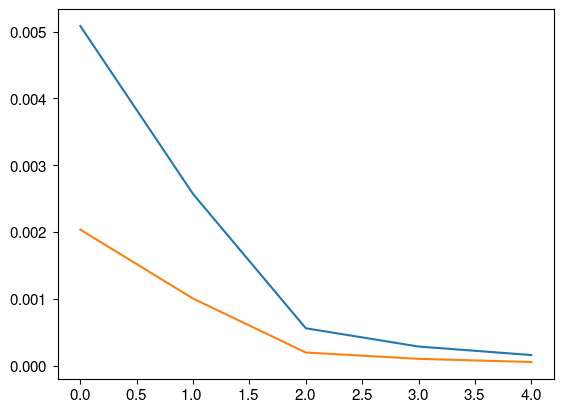

In [109]:
print(f"Erot MAE: {rmae[0]} eV")
print(f"Frot MAE: {fmae[0]} eV/Å")
plt.plot(rmae)
plt.plot(fmae)

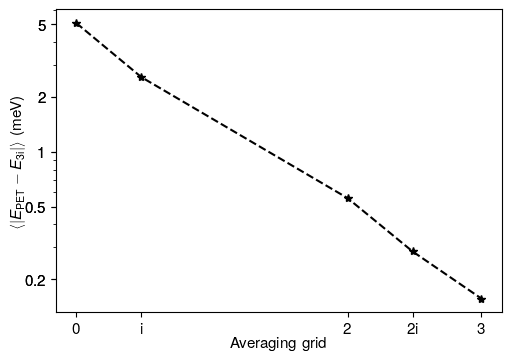

In [110]:
fig, ax = plt.subplot_mosaic(
    """
    A
    """
    ,figsize=(5,3.5),sharex=True,
    constrained_layout=True)

ax["A"].loglog([augs[a] for a in augs], 1e3*rmae, 'k--*')
ax["A"].set_ylabel(r"$\langle|E_\mathrm{PET}-E_\mathrm{3i}|\rangle$ (meV)", labelpad=0)
ax["A"].set_xlabel(r"Averaging grid", labelpad=0)
ax["A"].set_xticks(list(augs.values()))
ax["A"].set_xticklabels([r"$\mathrm{" + k + r"}$" for k in list(augs.keys())])
ax["A"].xaxis.set_minor_locator(plt.NullLocator())
ax["A"].yaxis.set_major_locator(plt.LogLocator(base=10.0, subs=[0.1, 0.2, 0.5, 1, 2, 5]))
ax["A"].yaxis.set_major_formatter(plt.FormatStrFormatter('%g'))


fig.savefig('figures/erot-test.pdf')
fig.savefig('figures/erot-test.svg')

## Comparison of convergence for various setups

In [111]:
# MD bulk
y_grads = []

for f in ["for_0", "f-aug-i", "f-aug-2", "f-aug-2i", "f-aug-3", "f-aug-3i"]:
    data = ase.io.read(f"data/nvt_errors/test-multi.{f}.extxyz", ":")
    y_grads.append(np.array([
        (d.arrays["forces"] if "forces" in d.arrays else d.arrays["forces_component_raw"] )       
        for d in data[1:]]
        ))

y_grads = np.array(y_grads)

fmae_md = []
for i in range(5):
    delta = (y_grads[i] - y_grads[5])
    fmae_md.append(np.abs(delta).mean())
fmae_md = np.array(fmae_md)


outs, _ = ipi.read_output("data/nvt_errors/test-multi.delta")
y_pred = ha2ev*outs["pot_component_raw(0)"][1:] # rebase and convert to eV
y_pred -= y_pred.mean() 

rmae_md = []
for i in range(5):
    delta = (outs[f"pot_component_raw({i})"] - outs["pot_component_raw(5)"])[1:]    
    rmae_md.append(np.abs(delta).mean()*ha2ev)
rmae_md = np.array(rmae_md)

In [112]:
# MD mol
y_grads = []

for f in ["for_0", "f-aug-i", "f-aug-2", "f-aug-2i", "f-aug-3", "f-aug-3i"]:
    data = ase.io.read(f"data/mol_errors/test-multi.{f}.extxyz", ":")
    y_grads.append(np.array([
        (d.arrays["forces"] if "forces" in d.arrays else d.arrays["forces_component_raw"] )       
        for d in data[1:400]]
        ))

y_grads = np.array(y_grads)

fmae_mol = []
for i in range(5):
    delta = (y_grads[i] - y_grads[5])
    fmae_mol.append(np.abs(delta).mean())
fmae_mol = np.array(fmae_mol)

outs, _ = ipi.read_output("data/mol_errors/test-multi.delta")
y_pred = ha2ev*outs["pot_component_raw(0)"][1:] # rebase and convert to eV
y_pred -= y_pred.mean() 

rmae_mol = []
for i in range(5):
    delta = (outs[f"pot_component_raw({i})"] - outs["pot_component_raw(5)"])[1:]    
    rmae_mol.append(np.abs(delta).mean()*ha2ev)
rmae_mol = np.array(rmae_mol)

In [113]:
print(f"Erot MAE NVT: {rmae_md[0]} eV")
print(f"Frot MAE NVT: {fmae_md[0]} eV/Å")
print(f"Erot MAE mol: {rmae_mol[0]} eV")
print(f"Frot MAE mol: {fmae_mol[0]} eV/Å")

Erot MAE NVT: 0.007938264481521339 eV
Frot MAE NVT: 0.0012142243888373216 eV/Å
Erot MAE mol: 0.0028218047825999174 eV
Frot MAE mol: 0.0117656494096352 eV/Å


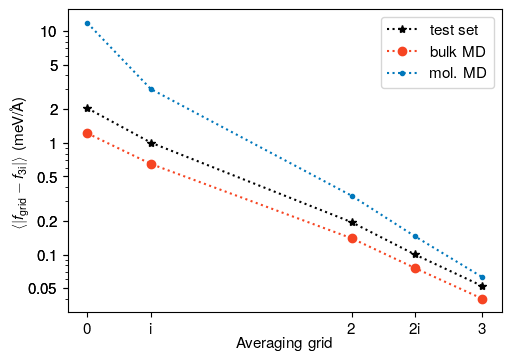

In [114]:
fig, ax = plt.subplot_mosaic(
    """
    A
    """
    ,figsize=(5,3.5),sharex=True,
    constrained_layout=True)

ax["A"].loglog([augs[a] for a in augs], 1e3*fmae, 'k:*', label="test set")
ax["A"].loglog([augs[a] for a in augs], 1e3*fmae_md, ':o', color=red, label="bulk MD")
ax["A"].loglog([augs[a] for a in augs], 1e3*fmae_mol, ':.', color=extra, label="mol. MD")
ax["A"].set_ylabel(r"$\langle|f_\mathrm{grid}-f_\mathrm{3i}|\rangle$ (meV/Å)", labelpad=0)
ax["A"].set_xlabel(r"Averaging grid", labelpad=0)
ax["A"].set_xticks(list(augs.values()))
ax["A"].set_xticklabels([r"$\mathrm{" + k + r"}$" for k in list(augs.keys())])
ax["A"].xaxis.set_minor_locator(plt.NullLocator())
ax["A"].yaxis.set_major_locator(plt.LogLocator(base=10.0, subs=[0.1, 0.2, 0.5, 1, 2, 5]))
ax["A"].yaxis.set_major_formatter(plt.FormatStrFormatter('%g'))
ax["A"].legend()

fig.savefig('figures/frot-comparison.pdf')
fig.savefig('figures/frot-comparison.svg')

# Ice convergence

In [115]:
# Define the dtype to read the file
dtype = [('struct', 'U2'), ('aug', 'U2'), ('start', 'f8'), ('relax', 'f8')]

# Load the data
ice_pet_base = np.loadtxt('data/base-nrg.dat', dtype=dtype)
ice_pet_fine = np.loadtxt('data/pet_3_2_w_100_lr_1e-5-nrg.dat', dtype=dtype)

nat = np.array([288, 288, 288, 576, 576, 1080, 1296, 1080, 2304])[:6]

In [116]:
ha2ev = 27.211386

symmetry error on starting configurations

In [117]:
ha2ev*np.mean(np.abs(ice_pet_base[np.where(ice_pet_base['aug']==['1'])]['start'] - ice_pet_base[np.where(ice_pet_base['aug']==['4'])]['start'])/nat)

1.4480409931792377e-05

In [118]:
ha2ev*np.mean(np.abs(ice_pet_fine[np.where(ice_pet_fine['aug']==['1'])]['start'] - ice_pet_fine[np.where(ice_pet_fine['aug']==['4'])]['start'])/nat)

1.1755864659430125e-05

symmetry error on relaxed configs

In [119]:
ha2ev*np.mean(np.abs(ice_pet_base[np.where(ice_pet_base['aug']==['1'])]['relax'] - ice_pet_base[np.where(ice_pet_base['aug']==['4'])]['relax'])/nat)

1.2436647974890855e-05

In [120]:
ha2ev*np.mean(np.abs(ice_pet_fine[np.where(ice_pet_fine['aug']==['1'])]['relax'] - ice_pet_fine[np.where(ice_pet_fine['aug']==['4'])]['relax'])/nat)

9.978075103879669e-06

symmetry error on relaxation energy

In [121]:
ha2ev*np.mean(np.abs(
    (ice_pet_base[np.where(ice_pet_base['aug']==['1'])]['relax'] - ice_pet_base[np.where(ice_pet_base['aug']==['1'])]['start'])
    - 
    (ice_pet_base[np.where(ice_pet_base['aug']==['4'])]['relax'] - ice_pet_base[np.where(ice_pet_base['aug']==['4'])]['start'])
)/nat)

2.1939914837866067e-06

In [122]:
ha2ev*np.mean(np.abs(
    (ice_pet_fine[np.where(ice_pet_fine['aug']==['1'])]['relax'] - ice_pet_fine[np.where(ice_pet_fine['aug']==['1'])]['start'])
    - 
    (ice_pet_fine[np.where(ice_pet_fine['aug']==['4'])]['relax'] - ice_pet_fine[np.where(ice_pet_fine['aug']==['4'])]['start'])
)/nat)

2.0294318867331755e-06

In [123]:
augs = {"1":1, "i": 2, "2" : 18, "2i": 36, "3" : 75, "3i": 150} # "label" : n_rotations

In [124]:
dv_base = np.zeros((len(augs), len(nat)))
dv_fine = np.zeros((len(augs), len(nat)))
for i, a in enumerate(augs):
    dv_base[i] = ice_pet_base[np.where(ice_pet_base['aug']==a)]['start']-ice_pet_base[np.where(ice_pet_base['aug']=="4")]['start']
    dv_fine[i] = ice_pet_fine[np.where(ice_pet_fine['aug']==a)]['start']-ice_pet_fine[np.where(ice_pet_fine['aug']=="4")]['start']

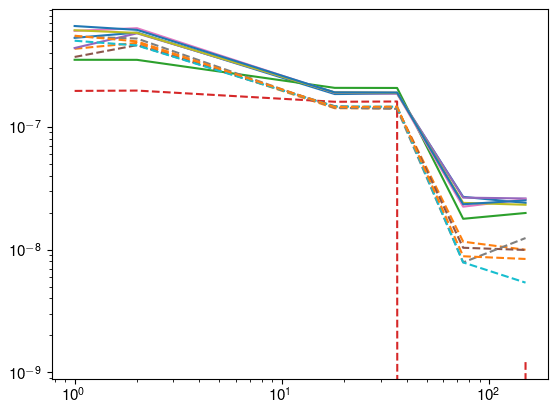

In [125]:
for i in range(len(nat)):
    plt.loglog(list(augs.values()), np.abs(dv_base[:,i])/nat[i])
    plt.loglog(list(augs.values()), np.abs(dv_fine[:,i])/nat[i], '--')